# Physics-informed microphysics neural network emulator

David John Gagne

The goal of this approach is to include more physical constraints and make the training easier for the microphysics emulator. 

The physics-informed neural network setup integrates the following components.

1. Predict the updated microphysical terms rather than tendencies. The tendencies have very weird distributions that are hard for one neural network to fit. The original values on the other hand are all greater than 0, so it is easier to ensure that outputs are always greater than 0 this way.
$y_{new} = y_{old} + y_{tend} dt$

$dt=1800 \text{ s}$

2. Keep all inputs and outputs in log space for training ideally.

3. Enforce mass conservation between cloud and rain. 
$ q_{ro} + q_{co} = q_{rn} + q_{cn}$

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from glob import glob
from os.path import join
import xarray as xr
import dask.dataframe as dd
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
from mlmicrophysics.models import DenseNeuralNetwork
%matplotlib inline

In [5]:
mp_path = "/glade/p/cisl/aiml/dgagne/cam_mp_files_run5_phys_parquet/"
mp_files = sorted(glob(join(mp_path, "*.parquet")))

In [6]:
mp_data = pd.concat([pd.read_parquet(mp_files[x]) for x in range(0, 400, 20)], ignore_index=True)

In [7]:
mp_data.columns

Index(['lat', 'lev', 'lon', 'P0', 'PS', 'depth', 'row', 'col', 'hyam', 'hybm',
       'pressure', 'temperature', 'RHO_CLUBB_lev', 'RHO_CLUBB_top',
       'RHO_CLUBB_bottom', 'QC_TAU_in', 'NC_TAU_in', 'QR_TAU_in', 'NR_TAU_in',
       'lamc', 'lamr', 'lcldm', 'n0r', 'pgam', 'precip_frac', 'qctend_MG2',
       'qctend_TAU', 'nctend_MG2', 'nctend_TAU', 'qrtend_MG2', 'qrtend_TAU',
       'nrtend_MG2', 'nrtend_TAU', 'QC_TAU_out', 'NC_TAU_out', 'QR_TAU_out',
       'NR_TAU_out', 'QC_MG2_out', 'NC_MG2_out', 'QR_MG2_out', 'NR_MG2_out',
       'time'],
      dtype='object')

In [8]:
mp_data["mass_diff_TAU"] = (mp_data["QC_TAU_out"] + mp_data["QR_TAU_out"]) - (mp_data["QC_TAU_in"] + mp_data["QR_TAU_in"])
mp_data["mass_diff_MG2"] = (mp_data["QC_MG2_out"] + mp_data["QR_MG2_out"]) - (mp_data["QC_TAU_in"] + mp_data["QR_TAU_in"])

In [9]:
mp_data["tend_diff_TAU"] = (mp_data["qctend_TAU"] + mp_data["qrtend_TAU"])
mp_data["tend_diff_MG2"] = (mp_data["qctend_MG2"] + mp_data["qrtend_MG2"])

In [10]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & 
                 np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)) / mp_data.shape[0]

0.6506558402540694

In [12]:
np.count_nonzero((mp_data["mass_diff_TAU"] == 0)) / mp_data.shape[0]

0.9100602477276009

In [13]:
np.count_nonzero((mp_data["tend_diff_TAU"] == 0)) / mp_data.shape[0]

0.8105487194736004

<AxesSubplot:>

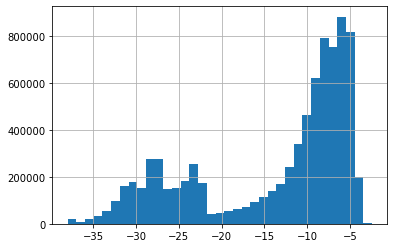

In [19]:
np.log10(np.maximum(mp_data["QR_TAU_in"], 1e-38)).hist(bins=35)

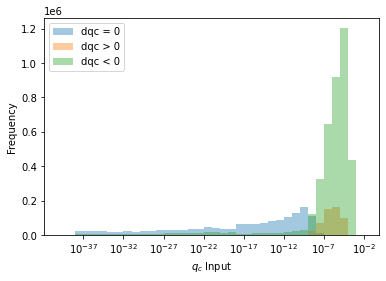

In [10]:
tz = mp_data["qctend_TAU"]== 0
tp = mp_data["qctend_TAU"]> 0
tn = mp_data["qctend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["QC_TAU_in"][tz], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc = 0")
plt.hist(mp_data["QC_TAU_in"][tp], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc > 0")
plt.hist(mp_data["QC_TAU_in"][tn], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqc < 0")

plt.gca().set_xscale("log")
plt.xlabel("$q_c$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("qc_tendency_properties.png")
#plt.gca().set_yscale("log")

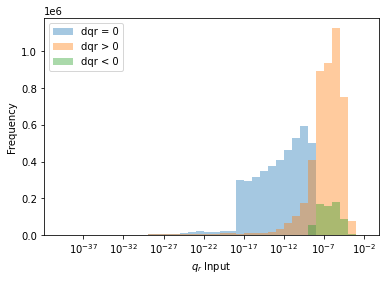

In [68]:
tz = mp_data["qrtend_TAU"]== 0
tp = mp_data["qrtend_TAU"]> 0
tn = mp_data["qrtend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["QR_TAU_in"][tz], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr = 0")
plt.hist(mp_data["QR_TAU_in"][tp], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr > 0")
plt.hist(mp_data["QR_TAU_in"][tn], bins=10. ** np.arange(-40., -1), alpha=0.4, label="dqr < 0")

plt.gca().set_xscale("log")
plt.xlabel("$q_r$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("qr_tendency_properties.png")
#plt.gca().set_yscale("log")

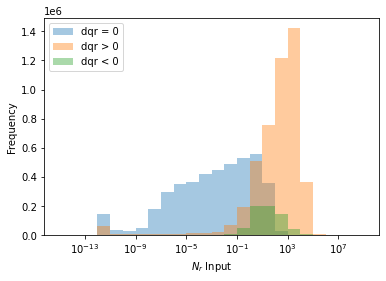

In [69]:
tz = mp_data["qrtend_TAU"]== 0
tp = mp_data["qrtend_TAU"]> 0
tn = mp_data["qrtend_TAU"] < 0


#plt.hist(mp_data["QC_TAU_in"], bins=10. ** np.arange(-40., -1))
plt.hist(mp_data["NR_TAU_in"][tz], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr = 0")
plt.hist(mp_data["NR_TAU_in"][tp], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr > 0")
plt.hist(mp_data["NR_TAU_in"][tn], bins=10. ** np.arange(-15., 10), alpha=0.4, label="dqr < 0")

plt.gca().set_xscale("log")
plt.xlabel("$N_r$ Input")
plt.ylabel("Frequency")
plt.legend()
plt.savefig("nr_tendency_properties.png")

Test mass conservation (mass diff should be 0). A significant proportion of grid cells have mass conserved

In [64]:
ix = (mp_data["tend_diff_TAU"] == 0) & (mp_data["mass_diff_TAU"] == 0) & np.all(mp_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_mass_data = mp_data.loc[ix].reset_index()

In [21]:
mp_mass_data.shape[0] / mp_data.shape[0]

0.6506558402540694

In [77]:
mp_mass_data.loc[:, "Q_mass_out"] = mp_mass_data[["QC_TAU_out", "QR_TAU_out"]].sum(axis=1)
mp_mass_data.loc[:, "Q_mass_in"] = mp_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)
mp_mass_data.loc[:, "QR_prop_out"] = mp_mass_data["QR_TAU_out"] / mp_mass_data["Q_mass_in"] 

In [76]:
np.min(mp_mass_data["Q_mass_in"] - mp_mass_data["Q_mass_out"])

0.0

(array([ 955034.,   83014.,   71616.,   71588.,   76949.,   88458.,
         174855.,  374447., 1399137., 1978383.]),
 array([8.122813e-31, 1.000000e-01, 2.000000e-01, 3.000000e-01,
        4.000000e-01, 5.000000e-01, 6.000000e-01, 7.000000e-01,
        8.000000e-01, 9.000000e-01, 1.000000e+00], dtype=float32),
 <BarContainer object of 10 artists>)

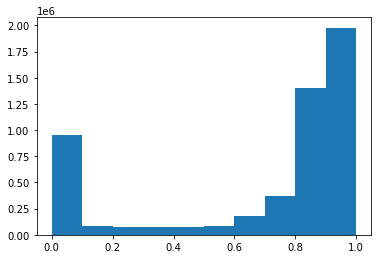

In [81]:
plt.hist(mp_mass_data["QC_TAU_out"] / mp_mass_data["Q_mass_out"])

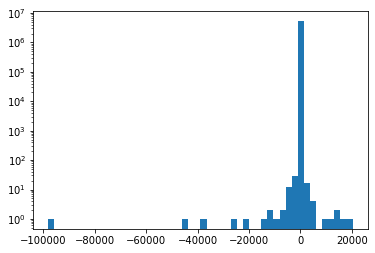

In [97]:
plt.hist(np.log10(mp_mass_data["NR_TAU_out"]) / np.log10(mp_mass_data["NR_TAU_in"]), bins=50)
plt.gca().set_yscale("log")

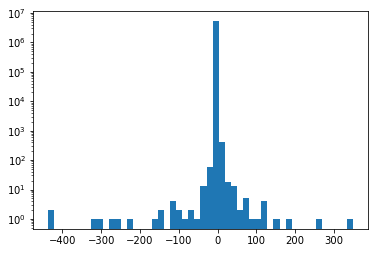

In [98]:
plt.hist(np.log10(mp_mass_data["NC_TAU_out"]) / np.log10(mp_mass_data["NC_TAU_in"]), bins=50)
plt.gca().set_yscale("log")

Text(0, 0.5, 'NR out')

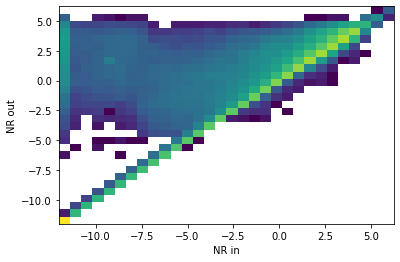

In [96]:
_ = plt.hist2d(np.log10(mp_mass_data["NR_TAU_in"]), np.log10(mp_mass_data["NR_TAU_out"]), bins=30, cmin=1, norm=LogNorm())
plt.xlabel("NR in")
plt.ylabel("NR out")

(array([1978383., 1399137.,  374447.,  174855.,   88458.,   76949.,
          71588.,   71616.,   83014.,  955034.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <BarContainer object of 10 artists>)

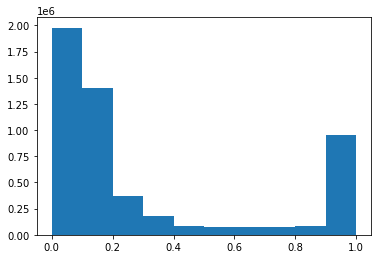

In [72]:
plt.hist(mp_mass_data["QR_TAU_out"] / mp_mass_data["Q_mass_out"])

In [78]:
input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in", "lcldm", "precip_frac"]
output_cols = ["QR_prop_out", "NC_TAU_out", "NR_TAU_out"]
scale_in = MinMaxScaler()
in_data = scale_in.fit_transform(np.log10(np.maximum(mp_mass_data[input_cols].values, 1e-38)))
out_data_raw = mp_mass_data[output_cols].values
out_data_log = np.log10(np.maximum(out_data_raw, 1e-38))

In [42]:
(np.log10(1e-6) - np.log10(0.5e-5)) ** 2

0.4885590669614941

In [91]:
from tensorflow.experimental.numpy import log10 as tflog10
def mass_loss(y_true_log, y_pred_log, scale_factor=2):
    
    y_true = 10 ** y_true_log
    y_pred = 10 ** y_pred_log
    mse_loss = tf.reduce_mean((y_true_log - y_pred_log) ** 2, axis=0)
    mass_in_true_l = tflog10(tf.reduce_sum(y_true[:, 0:2], axis=1))
    mass_out_pred_l = tflog10(tf.reduce_sum(y_pred[:, 2:4], axis=1))
    mass_in_pred_l = tflog10(tf.reduce_sum(y_pred[:, 0:2], axis=1))

    mass_diff_loss = tf.reduce_mean(tf.abs(mass_in_true_l - mass_out_pred_l))
    mass_diff_loss += tf.reduce_mean(tf.abs(mass_in_true_l - mass_in_pred_l))
    loss = tf.reduce_sum(mse_loss) + scale_factor * mass_diff_loss
    loss = tf.reduce_sum(mse_loss)
    return loss

In [23]:
mod = Sequential()
mod.add(Dense(64, input_shape=(len(input_cols),)))
mod.add(Activation("relu"))
mod.add(Dense(len(output_cols)))

2021-07-22 08:41:49.816475: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-22 08:41:49.817626: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-22 08:41:49.852588: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-22 08:41:49.852654: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (crhtc56): /proc/driver/nvidia/version does not exist
2021-07-22 08:41:49.866781: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX512F
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-07-22 08:41:49.86

In [36]:
mod.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5))
mod.fit(in_data, out_data_log, epochs=30, batch_size=1024, verbose=1)

Epoch 1/30
5150/5150 [==============================] - 3s 605us/step - loss: 0.0429
Epoch 2/30
5150/5150 [==============================] - 3s 600us/step - loss: 0.0426
Epoch 3/30
5150/5150 [==============================] - 3s 610us/step - loss: 0.0421
Epoch 4/30
5150/5150 [==============================] - 3s 604us/step - loss: 0.0418
Epoch 5/30
5150/5150 [==============================] - 3s 603us/step - loss: 0.0416
Epoch 6/30
5150/5150 [==============================] - 3s 600us/step - loss: 0.0411
Epoch 7/30
5150/5150 [==============================] - 3s 607us/step - loss: 0.0411
Epoch 8/30
5150/5150 [==============================] - 3s 619us/step - loss: 0.0410
Epoch 9/30
5150/5150 [==============================] - 3s 613us/step - loss: 0.0406
Epoch 10/30
5150/5150 [==============================] - 3s 599us/step - loss: 0.0402
Epoch 11/30
5150/5150 [==============================] - 3s 609us/step - loss: 0.0401
Epoch 12/30
5150/5150 [==============================] - 3s 603

In [25]:
hist = _
print(hist)

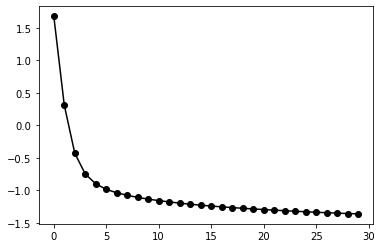

In [30]:
plt.plot(np.log10(hist.history["loss"]), 'ko-')

In [64]:
# Slow manual training loop. Only use for debugging

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
train_dataset = tf.data.Dataset.from_tensor_slices((in_data.astype("float32"), 
                                                    out_data_log.astype("float32")))
for epoch in range(30):
    train_dataset = train_dataset.shuffle(buffer_size=4096).batch(4096)
    print("Epoch", epoch)
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        with tf.GradientTape() as tape:
            outs = mod(x_batch_train)
            loss_val = mass_loss(y_batch_train, outs)
        grads = tape.gradient(loss_val, mod.trainable_weights)
        optimizer.apply_gradients(zip(grads, mod.trainable_weights))
    print(loss_val)


Epoch 0


KeyboardInterrupt: 

In [32]:
mp_test_data = pd.read_parquet(mp_files[600])
dt = 60 * 30 #minutes
for var in ["QC", "QR", "NC", "NR"]:
    mp_test_data[var + "_TAU_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_TAU"] * dt)
    mp_test_data[var + "_MG2_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_MG2"] * dt)
mp_test_data["tend_diff_TAU"] = (mp_test_data["qctend_TAU"] + mp_test_data["qrtend_TAU"])
mp_test_data["mass_diff_TAU"] = (mp_test_data["QC_TAU_out"] + mp_test_data["QR_TAU_out"]) - (mp_test_data["QC_TAU_in"] + mp_test_data["QR_TAU_in"])

ixt = (mp_test_data["tend_diff_TAU"] == 0) & (mp_test_data["mass_diff_TAU"] == 0) & \
    np.all(mp_test_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_test_mass_data = mp_test_data.loc[ixt]

in_test_data = scale_in.transform(np.log10(np.maximum(mp_test_mass_data[input_cols].values, 1e-38)))
out_test_data = np.log10(np.maximum(mp_test_mass_data[output_cols].values, 1e-38))

In [37]:

mod_preds = mod.predict(in_test_data, batch_size=1024)

In [38]:
from sklearn.metrics import r2_score
for i in range(3):
    print(output_cols[i], r2_score(out_test_data[:, i], mod_preds[:, i]))

QR_TAU_out 0.9994522781598787
NC_TAU_out 0.9998619349764142
NR_TAU_out 0.9992522874186783


In [39]:
mod_preds[:, 0].min()

-38.158497

(array([2.2000e+01, 2.2000e+01, 4.6000e+01, 3.2400e+02, 6.0800e+02,
        6.5600e+02, 1.0560e+03, 2.3270e+03, 4.2190e+03, 3.8980e+03,
        5.1820e+03, 2.0198e+04, 4.9370e+03, 6.2900e+03, 5.8220e+03,
        7.9120e+03, 5.0100e+02, 5.8500e+02, 9.4800e+02, 1.5520e+03,
        3.0780e+03, 4.0720e+03, 3.4110e+03, 2.0130e+03, 2.2790e+03,
        2.1090e+03, 2.0270e+03, 2.0150e+03, 1.7080e+03, 1.4440e+03,
        1.5130e+03, 1.7870e+03, 1.9370e+03, 1.9740e+03, 2.1540e+03,
        2.4560e+03, 2.9160e+03, 3.3560e+03, 4.0720e+03, 4.9710e+03,
        6.2810e+03, 7.3860e+03, 6.6220e+03, 2.9980e+03, 5.6940e+03,
        1.1057e+04, 1.7773e+04, 2.7369e+04, 3.7670e+04, 1.2740e+04]),
 array([-37.89175  , -37.198036 , -36.50432  , -35.810604 , -35.11689  ,
        -34.423172 , -33.729458 , -33.035744 , -32.342026 , -31.648312 ,
        -30.954596 , -30.26088  , -29.567165 , -28.87345  , -28.179733 ,
        -27.48602  , -26.792303 , -26.098587 , -25.404873 , -24.711157 ,
        -24.01744  , -23.3

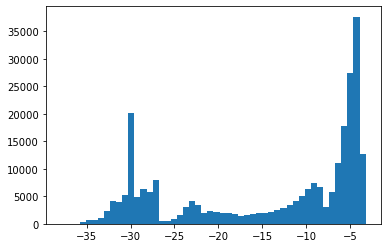

In [44]:
plt.hist(np.log10(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)), bins=50)

(array([  998.,   324.,   889.,  1507.,  4772.,  7081., 24750.,  9481.,
        13289.,  2799.,  1718.,  3806.,  9327.,  8199.,  1766.,  2016.,
         2278.,  2546.,  3696.,  4510.,  4969.,  5815.,  7137., 10087.,
        13274., 28819., 25120., 35019., 17915.,    80.]),
 array([-38.769226 , -37.55813  , -36.34703  , -35.135933 , -33.924835 ,
        -32.713737 , -31.50264  , -30.291544 , -29.080446 , -27.869349 ,
        -26.65825  , -25.447153 , -24.236055 , -23.024958 , -21.81386  ,
        -20.602762 , -19.391665 , -18.180567 , -16.96947  , -15.758372 ,
        -14.547275 , -13.336177 , -12.125079 , -10.913981 ,  -9.702885 ,
         -8.491787 ,  -7.2806892,  -6.0695915,  -4.858494 ,  -3.6473963,
         -2.4362988], dtype=float32),
 <BarContainer object of 30 artists>)

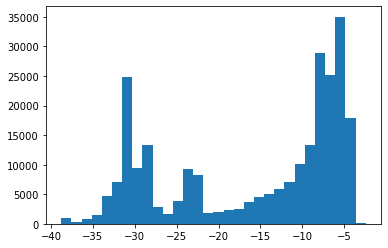

In [46]:
plt.hist(mod_preds[:, 0], bins=30)

(array([[9.8700e+02, 3.5000e+01,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [6.1000e+02, 1.1494e+04, 5.2000e+01,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [1.2300e+02, 1.5980e+03, 4.0619e+04, 8.9000e+01,        nan,
                nan,        nan,        nan,        nan,        nan],
        [6.4000e+01, 4.2000e+01, 6.3910e+03, 4.5740e+03, 4.2700e+02,
                nan,        nan,        nan,        nan,        nan],
        [9.8000e+01, 2.2000e+01, 1.6000e+02, 2.0380e+03, 1.2507e+04,
         2.8000e+01,        nan,        nan,        nan,        nan],
        [8.1000e+01, 2.1000e+01, 5.5000e+01, 9.6100e+02, 4.2430e+03,
         3.9420e+03,        nan,        nan,        nan,        nan],
        [7.9000e+01, 1.7000e+01, 6.1000e+01, 1.7400e+02, 8.3500e+02,
         9.9400e+02, 7.2050e+03,        nan,        nan,        nan],
        [1.0100e+02, 4.9000

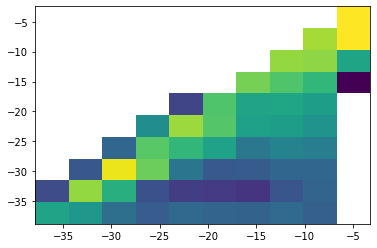

In [53]:
plt.hist2d(np.log10(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)), mod_preds[:, 0], cmin=1, norm=LogNorm())

(array([[1.0080e+03, 1.4000e+01,        nan,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [1.0100e+02, 1.2046e+04, 9.0000e+00,        nan,        nan,
                nan,        nan,        nan,        nan,        nan],
        [1.2400e+02, 3.8000e+02, 4.1918e+04, 7.0000e+00,        nan,
                nan,        nan,        nan,        nan,        nan],
        [3.9300e+02, 5.3500e+02, 1.2420e+03, 9.3040e+03, 2.4000e+01,
                nan,        nan,        nan,        nan,        nan],
        [2.2390e+03, 1.2460e+03, 1.5360e+03, 2.6460e+03, 7.0650e+03,
         1.2100e+02,        nan,        nan,        nan,        nan],
        [7.9200e+02, 4.7700e+02, 5.2300e+02, 5.8600e+02, 7.8900e+02,
         6.0980e+03, 3.8000e+01,        nan,        nan,        nan],
        [9.0100e+02, 6.2300e+02, 6.6100e+02, 8.3600e+02, 1.2360e+03,
         1.3800e+03, 3.6790e+03, 4.9000e+01,        nan,        nan],
        [1.0840e+03, 7.4300

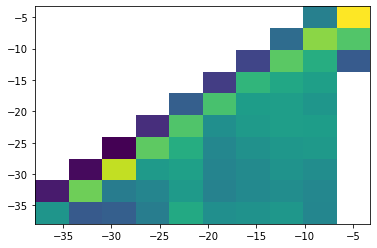

In [57]:
plt.hist2d(np.log10(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1)), np.log10(np.maximum(mp_test_mass_data["QC_TAU_out"], 1e-38)), cmin=1, norm=LogNorm())

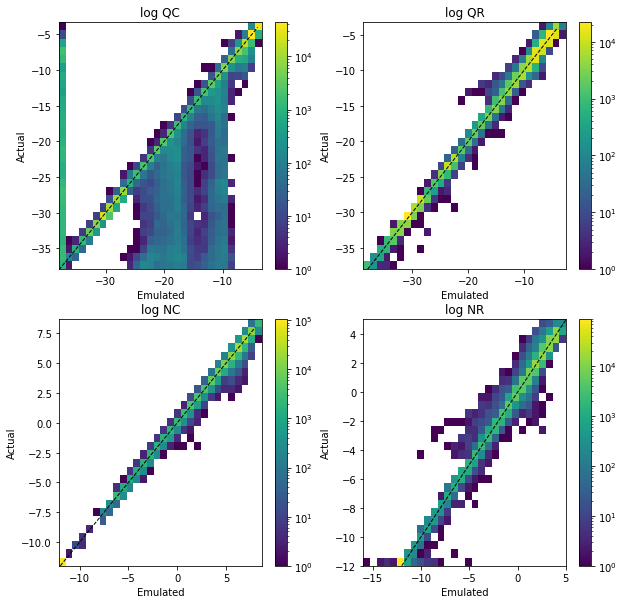

In [59]:
plt.figure(figsize=(10, 10))
for i in range(3):
    plt.subplot(2, 2, i + 2)
    plt.hist2d(mod_preds[:, i], out_test_data[:,i], cmin=1, norm=LogNorm(), bins=30)
    plt.xlabel("Emulated")
    plt.ylabel("Actual")
    plt.title("log " + output_cols[i].split("_")[0])
    diag = np.arange(out_test_data[:, i].min(), out_test_data[:, i].max(), 1)
    plt.plot(diag, diag, 'k--', lw=1)
    plt.colorbar()
plt.subplot(2, 2, 1)
qc_out = np.log10(np.maximum(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1) - 10 ** mod_preds[:, 0], 1e-38))
_ = plt.hist2d(qc_out, np.log10(np.maximum(mp_test_mass_data["QC_TAU_out"], 1e-38)), cmin=1, norm=LogNorm(), bins=30)
plt.xlabel("Emulated")
plt.ylabel("Actual")
diag = np.arange(-38, -3, 1)
plt.plot(diag, diag, 'k--', lw=1)
plt.colorbar()
plt.title("log QC")
plt.savefig("mass_hist_out.png", dpi=200, bbox_inches="tight")

In [46]:
qmass_in = np.log10(np.maximum(mp_test_mass_data[["QC_TAU_in", "QR_TAU_in"]].sum(axis=1), 1e-38))

(array([2.5200e+02, 3.1000e+01, 3.5000e+01, 5.1000e+01, 6.5000e+01,
        6.1000e+01, 7.7000e+01, 1.1500e+02, 1.2700e+02, 1.8100e+02,
        2.8600e+02, 4.1900e+02, 9.0400e+02, 1.2470e+03, 6.4400e+02,
        8.0000e+02, 1.0270e+03, 1.3441e+04, 1.5858e+04, 1.6750e+04,
        1.7771e+04, 1.9332e+04, 2.0478e+04, 2.3406e+04, 2.7231e+04,
        3.1745e+04, 2.7063e+04, 2.9885e+04, 2.5208e+04, 5.0600e+02]),
 array([-38.        , -36.84019937, -35.68039874, -34.52059811,
        -33.36079749, -32.20099686, -31.04119623, -29.8813956 ,
        -28.72159497, -27.56179434, -26.40199372, -25.24219309,
        -24.08239246, -22.92259183, -21.7627912 , -20.60299057,
        -19.44318995, -18.28338932, -17.12358869, -15.96378806,
        -14.80398743, -13.6441868 , -12.48438617, -11.32458555,
        -10.16478492,  -9.00498429,  -7.84518366,  -6.68538303,
         -5.5255824 ,  -4.36578178,  -3.20598115]),
 <BarContainer object of 30 artists>)

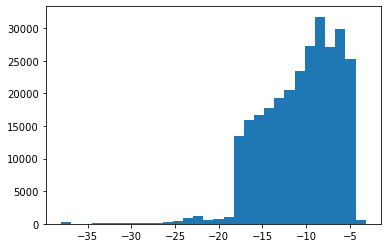

In [85]:
plt.hist(np.log10(np.maximum(mp_test_mass_data["QR_TAU_in"], 1e-38,)), bins=30)

In [28]:
ds = xr.open_dataset("/glade/p/cisl/aiml/dgagne/TAU_run5_full/TAU_run5.cam.h1.0002-06-16-21600.nc")

In [29]:
ds["QT_TAU_in"] = ds["QR_TAU_in"] + ds["QC_TAU_in"]

In [107]:
dt = 1
ds["QR_TAU_out"] = ds["QR_TAU_in"] + dt * ds["qrtend_TAU"]
ds["QC_TAU_out"] = ds["QC_TAU_in"] + dt * ds["qctend_TAU"]
ds["NR_TAU_out"] = ds["NR_TAU_in"] + dt * ds["nrtend_TAU"]
ds["NC_TAU_out"] = ds["NC_TAU_in"] + dt * ds["nctend_TAU"]

In [31]:
ds["QT_TAU_out"] = ds["QR_TAU_out"] + ds["QC_TAU_out"]

In [32]:
ds["mass_diff"] = ds["QT_TAU_in"] - ds["QT_TAU_out"]

In [33]:
mass_diff_vals = ds["mass_diff"].values.ravel()

In [108]:
np.count_nonzero(np.logical_and(ds["QC_TAU_in"] > 0, ds["QC_TAU_out"] >= 0)) / np.count_nonzero(ds["QC_TAU_in"] > 0)

0.9685929659188537

In [35]:
np.count_nonzero(mass_diff_vals == 0) / mass_diff_vals.size

0.9771775422272859

In [36]:
np.count_nonzero(ds["qrtend_TAU"] + ds["qctend_TAU"] == 0) / mass_diff_vals.size

0.9322071405104649

In [42]:
qr = ds["NR_TAU_in"].values
qr[qr > 0].min()

1e-12

In [61]:
np.count_nonzero(np.logical_and((ds["QC_TAU_in"] > 0), (ds["QR_TAU_in"] == 0))) / ds["QC_TAU_in"].size

0.0007707572277681328

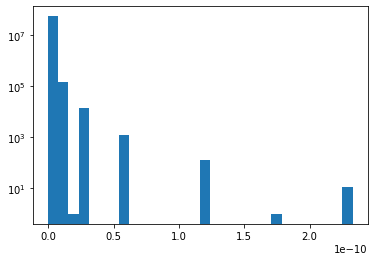

In [37]:
plt.hist(np.abs(mass_diff_vals), bins=30)
plt.gca().set_yscale("log")

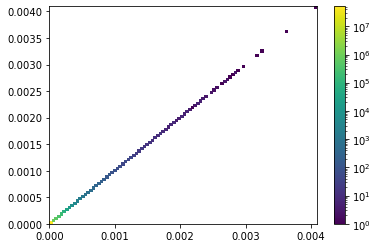

In [38]:
plt.hist2d(ds["QT_TAU_in"].values.ravel(), ds["QT_TAU_out"].values.ravel(), bins=100, cmin=1, norm=LogNorm())
plt.colorbar()

In [91]:
qr_orig = np.log10(np.maximum(ds["QR_TAU_in"].values.ravel(), 1e-38))

(array([ 755932.,  789581.,  465151.,  414486.,  182812.,  260760.,
         485545.,  579836., 1532863., 1142724.,  368730.,  485590.,
         786688., 1413532., 3168386.,  543705.,  615184.,  755780.,
         740132.,  453738.,  445334.,  474292.,  522459.,  578050.,
         644857.,  772637.,  935316., 1142088., 1455270., 1652457.,
        1796926., 2289931.]),
 array([-37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26, -25,
        -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12,
        -11, -10,  -9,  -8,  -7,  -6,  -5]),
 <BarContainer object of 32 artists>)

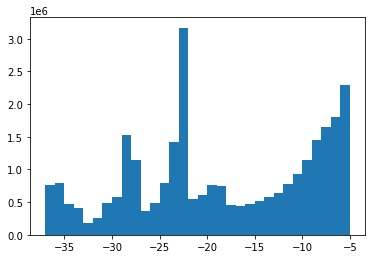

In [92]:
plt.hist(qr_orig, bins=np.arange(-37, -4, 1))

In [101]:

input_cols = ["QC_TAU_in", "QR_TAU_in", "NC_TAU_in", "NR_TAU_in"]
output_col = "QR_TAU_in"
scale_in = MinMaxScaler()
in_data = scale_in.fit_transform(np.log10(np.maximum(mp_mass_data[input_cols].values, 1e-38)))
out_data_qr = mp_mass_data[output_col] / mp_mass_data["Q_mass_in"]
mp_test_data = pd.read_parquet(mp_files[500])
dt = 60 * 30 #minutes
for var in ["QC", "QR", "NC", "NR"]:
    mp_test_data[var + "_TAU_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_TAU"] * dt)
    mp_test_data[var + "_MG2_out"] = (mp_test_data[var + "_TAU_in"] +  mp_test_data[var.lower() + "tend_MG2"] * dt)
mp_test_data["tend_diff_TAU"] = (mp_test_data["qctend_TAU"] + mp_test_data["qrtend_TAU"])
mp_test_data["mass_diff_TAU"] = (mp_test_data["QC_TAU_out"] + mp_test_data["QR_TAU_out"]) - (mp_test_data["QC_TAU_in"] + mp_test_data["QR_TAU_in"])

ixt = (mp_test_data["tend_diff_TAU"] == 0) & (mp_test_data["mass_diff_TAU"] == 0) & \
    np.all(mp_test_data[["QC_TAU_out", "QR_TAU_out", "NC_TAU_out", "NR_TAU_out"]] >= 0, axis=1)
mp_test_mass_data = mp_test_data.loc[ixt]

in_test_data = scale_in.transform(np.log10(np.maximum(mp_test_mass_data[input_cols].values, 1e-38)))
out_test_qr = mp_test_mass_data[output_col] / mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1)

In [115]:
dnn = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=50, activation="tanh", output_activation="sigmoid", batch_size=256, epochs=30, verbose=1)
dnn.fit(in_data, out_data_qr)


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 50)                250       
_________________________________________________________________
dense_01 (Dense)             (None, 1)                 51        
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
20600/20600 [==============================] - 9s 394us/step - loss: 0.0649
Epoch 2/30
20600/20600 [==============================] - 8s 409us/step - loss: 0.0082
Epoch 3/30
20600/20600 [==============================] - 9s 433us/step - loss: 0.0036
Epoch 4/30
20600/20600 [==============================] - 8s 405us/step - loss: 0.0023
Epoch 5/30
20600/20600 [===================

{'loss': [0.034966886043548584,
  0.006516441237181425,
  0.003220099024474621,
  0.002167349448427558,
  0.0018628084799274802,
  0.00193233962636441,
  0.0017003839602693915,
  0.001910739578306675,
  0.0016668267780914903,
  0.0020154977682977915,
  0.0017959446413442492,
  0.0018784358398988843,
  0.0015716400230303407,
  0.0018877763068303466,
  0.0019181394018232822,
  0.0017480113310739398,
  0.001949080964550376,
  0.0019530062563717365,
  0.0016390159726142883,
  0.001882614684291184,
  0.0016736369580030441,
  0.001955358311533928,
  0.001902226940728724,
  0.0018447514157742262,
  0.0013804268091917038,
  0.0017426741542294621,
  0.001199300866574049,
  0.001354888896457851,
  0.0014443148393183947,
  0.0012432235525920987]}

In [119]:
out_pred_qr_mix = dnn.predict(in_test_data)
out_pred_qr_total = out_pred_qr_mix * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1)
out_pred_qc_total = (1 - out_pred_qr_mix) * mp_test_mass_data[["QR_TAU_in", "QC_TAU_in"]].sum(axis=1)

/glade/work/dgagne/miniconda3/envs/mlmicro/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


(-10.0, -2.0)

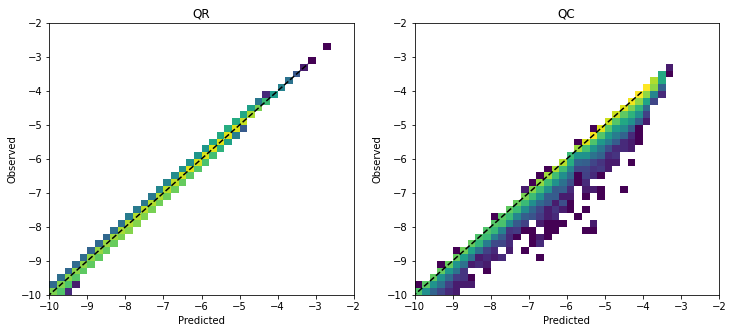

In [146]:
ix = mp_test_mass_data[output_col] > 0
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist2d(np.log10(out_pred_qr_total[ix]), np.log10(mp_test_mass_data.loc[ix, output_col]), cmin=1, bins=np.arange(-38, -2, 0.2), norm=LogNorm())
plt.plot(np.arange(-38, -3, 0.2), np.arange(-38, -3, 0.2), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QR")
plt.xlim(-10, -2)
plt.ylim(-10, -2)
plt.subplot(1, 2, 2)
ix = mp_test_mass_data["QC_TAU_out"] > 0
plt.hist2d(np.log10(out_pred_qc_total[ix]), np.log10(mp_test_mass_data.loc[ix, "QC_TAU_out"]), cmin=1, bins=np.arange(-38, -2, 0.2), norm=LogNorm())
plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("QC")
plt.xlim(-10, -2)
plt.ylim(-10, -2)

In [140]:
dnn_nr = DenseNeuralNetwork(hidden_layers=1, hidden_neurons=100, activation="tanh", output_activation="linear", batch_size=256, epochs=40, 
                            l2_weight=0, verbose=1)
dnn_nr.fit(in_data, np.log10(mp_mass_data["NR_TAU_out"]))

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 4)]               0         
_________________________________________________________________
dense_00 (Dense)             (None, 100)               500       
_________________________________________________________________
dense_01 (Dense)             (None, 1)                 101       
Total params: 601
Trainable params: 601
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
20600/20600 [==============================] - 10s 472us/step - loss: 2.7958
Epoch 2/40
20600/20600 [==============================] - 10s 472us/step - loss: 0.1609
Epoch 3/40
20600/20600 [==============================] - 10s 474us/step - loss: 0.1313
Epoch 4/40
20600/20600 [==============================] - 10s 472us/step - loss: 0.1148
Epoch 5/40
20600/20600 [===============

{'loss': [0.7180818319320679,
  0.15104366838932037,
  0.126512810587883,
  0.11311338096857071,
  0.10539574176073074,
  0.09973710030317307,
  0.09485384821891785,
  0.09099218249320984,
  0.08779978007078171,
  0.0850488543510437,
  0.08277875185012817,
  0.08081736415624619,
  0.07911494374275208,
  0.07754027098417282,
  0.07607919722795486,
  0.07474366575479507,
  0.0734889805316925,
  0.07214546948671341,
  0.07101195305585861,
  0.06977994740009308,
  0.06871077418327332,
  0.06766107678413391,
  0.06646815687417984,
  0.06529919058084488,
  0.06414420157670975,
  0.06297782063484192,
  0.06193380430340767,
  0.060999639332294464,
  0.06004547327756882,
  0.059301022440195084,
  0.05848964676260948,
  0.057822179049253464,
  0.05715567618608475,
  0.05652051046490669,
  0.05587080866098404,
  0.05543198809027672,
  0.054805126041173935,
  0.05431303381919861,
  0.05380377545952797,
  0.05334550887346268]}

In [141]:
out_pred_nr_mix = dnn_nr.predict(in_test_data)

Text(0.5, 1.0, 'NR')

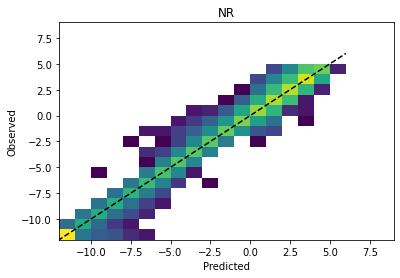

In [142]:
plt.hist2d(out_pred_nr_mix, np.log10(mp_test_mass_data.loc[ix, "NR_TAU_out"]), cmin=1, bins=np.arange(-12, 10), norm=LogNorm())
plt.plot(np.arange(-15, 7), np.arange(-15, 7), 'k--')
plt.xlabel("Predicted")
plt.ylabel("Observed")
plt.title("NR")

In [110]:
ix = mp_test_mass_data[output_col] > 0
plt.hist2d(np.log10(out_pred_qr_total[ix]), np.log10(mp_test_mass_data.loc[ix, output_col]), cmin=1, bins=np.arange(-38, -2), norm=LogNorm())
plt.plot(np.arange(-38, -3), np.arange(-38, -3), 'k--')

0         3.587259e-23
1         2.818454e-23
2         1.609617e-20
3         1.870836e-20
4         3.559898e-20
              ...     
411512    9.715268e-07
411513    9.715268e-07
411514    9.715175e-07
411515    9.715134e-07
411516    9.715134e-07
Name: QR_TAU_out, Length: 264443, dtype: float32

# Experiments to run
1. Train neural net on qc/total mass vs qr / total mass and see how that affects the resulting error scores for qc and qr.
2. Training multi-output model vs. single output models for qc/qr and nc and nr.
3. Perform random search on NN architectures and calculate partial dependence plots on NN hyperparameters.
4. Update Fortran code to support new neural network models.